# :D

In [16]:
print(":D")

:D


# CELL 1: Import Libraries


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, deque
import heapq
import time
import csv
from typing import List, Tuple, Dict, Set
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


# CELL 2: Define Problem Constants


In [18]:
# Terrain type mappings
TERRAIN_TYPES = {
    1: "City",
    2: "Mountain",
    3: "Grassland",
    4: "Forest",
    5: "Desert",
    6: "Swamp"
}

# Transport costs (cost added to path when adjacent to terrain)
TRANSPORT_COSTS = {
    1: 20,   # City
    2: 60,   # Mountain
    3: 40,   # Grassland
    4: 50,   # Forest
    5: 90,   # Desert
    6: 110   # Swamp
}

# Inventory setup costs (cost added for each adjacent terrain)
INVENTORY_SETUP_COSTS = {
    1: 1200,  # City
    2: 600,   # Mountain
    3: 1000,  # Grassland
    4: 700,   # Forest
    5: 500,   # Desert
    6: 300    # Swamp
}

# Inventory capacities based on surrounding terrain
INVENTORY_CAPACITIES = {
    1: 15,   # City
    2: 20,   # Mountain
    3: 15,   # Grassland
    4: 10,   # Forest
    5: 30,   # Desert
    6: 25    # Swamp
}

# Problem constraints
MIN_INVENTORIES = 2
MAX_INVENTORIES = 8
MIN_DISTANCE = 3
SHORTAGE_PENALTY = 10000

print("✓ Constants defined!")
print(f"Transport costs: {TRANSPORT_COSTS}")
print(f"Inventory constraints: MIN={MIN_INVENTORIES}, MAX={MAX_INVENTORIES}")

✓ Constants defined!
Transport costs: {1: 20, 2: 60, 3: 40, 4: 50, 5: 90, 6: 110}
Inventory constraints: MIN=2, MAX=8


# CELL 3: Load and Visualize the Map


✓ Map loaded successfully!
Map dimensions: 20 rows × 30 columns
Total cells: 600


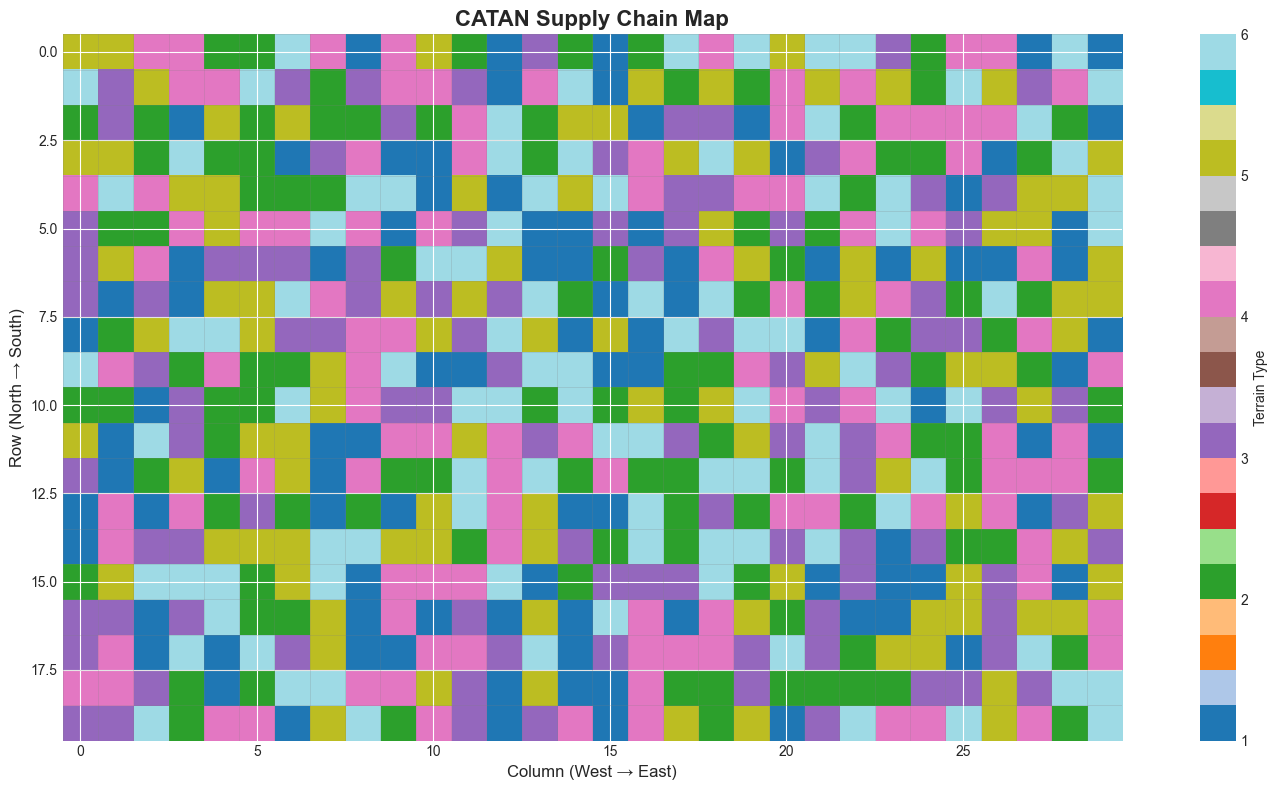


Terrain Distribution:
     Terrain  Count  Percentage
0       City     95       15.83
1   Mountain    105       17.50
2  Grassland     98       16.33
3     Forest    108       18.00
4     Desert     97       16.17
5      Swamp     97       16.17


In [19]:
# Load the map
MAP_FILE = "map.csv"  # Update this path if needed

# Read map from CSV
map_grid = []
with open(MAP_FILE, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if row:  # Skip empty rows
            map_grid.append([int(x) for x in row])

map_grid = np.array(map_grid)
rows, cols = map_grid.shape

print(f"✓ Map loaded successfully!")
print(f"Map dimensions: {rows} rows × {cols} columns")
print(f"Total cells: {rows * cols}")

# Visualize the map
plt.figure(figsize=(16, 8))
plt.imshow(map_grid, cmap='tab20', interpolation='nearest')
plt.colorbar(label='Terrain Type', ticks=[1,2,3,4,5,6])
plt.title('CATAN Supply Chain Map', fontsize=16, fontweight='bold')
plt.xlabel('Column (West → East)', fontsize=12)
plt.ylabel('Row (North → South)', fontsize=12)

# Add grid lines
for i in range(rows + 1):
    plt.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.3)
for j in range(cols + 1):
    plt.axvline(j - 0.5, color='gray', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# Show terrain distribution
unique, counts = np.unique(map_grid, return_counts=True)
terrain_dist = pd.DataFrame({
    'Terrain': [TERRAIN_TYPES[t] for t in unique],
    'Count': counts,
    'Percentage': (counts / (rows * cols) * 100).round(2)
})
print("\nTerrain Distribution:")
print(terrain_dist)

# CELL 4: Define Harbor and Store Data


✓ Harbor and Store data loaded!

Supply Information:
  Total Supply (All Harbors): 855
  Number of Active Harbors: 8
  Average Supply per Active Harbor: 106.88

Demand Information:
  Total Demand (All Stores): 855
  Number of Active Stores: 10
  Average Demand per Active Store: 85.50

Supply/Demand Balance:
  Supply - Demand = 0
  ✓ Supply is sufficient (surplus: 0)

Detailed Supply & Demand by Row:
    Row  Harbor Supply  Store Demand  Net Flow
0     0              0            40       -40
1     1             85             0        85
2     2              0            95       -95
3     3            120             0       120
4     4              0           120      -120
5     5             95             0        95
6     6              0            85       -85
7     7              0             0         0
8     8            150             0       150
9     9              0           110      -110
10   10              0             0         0
11   11            110           

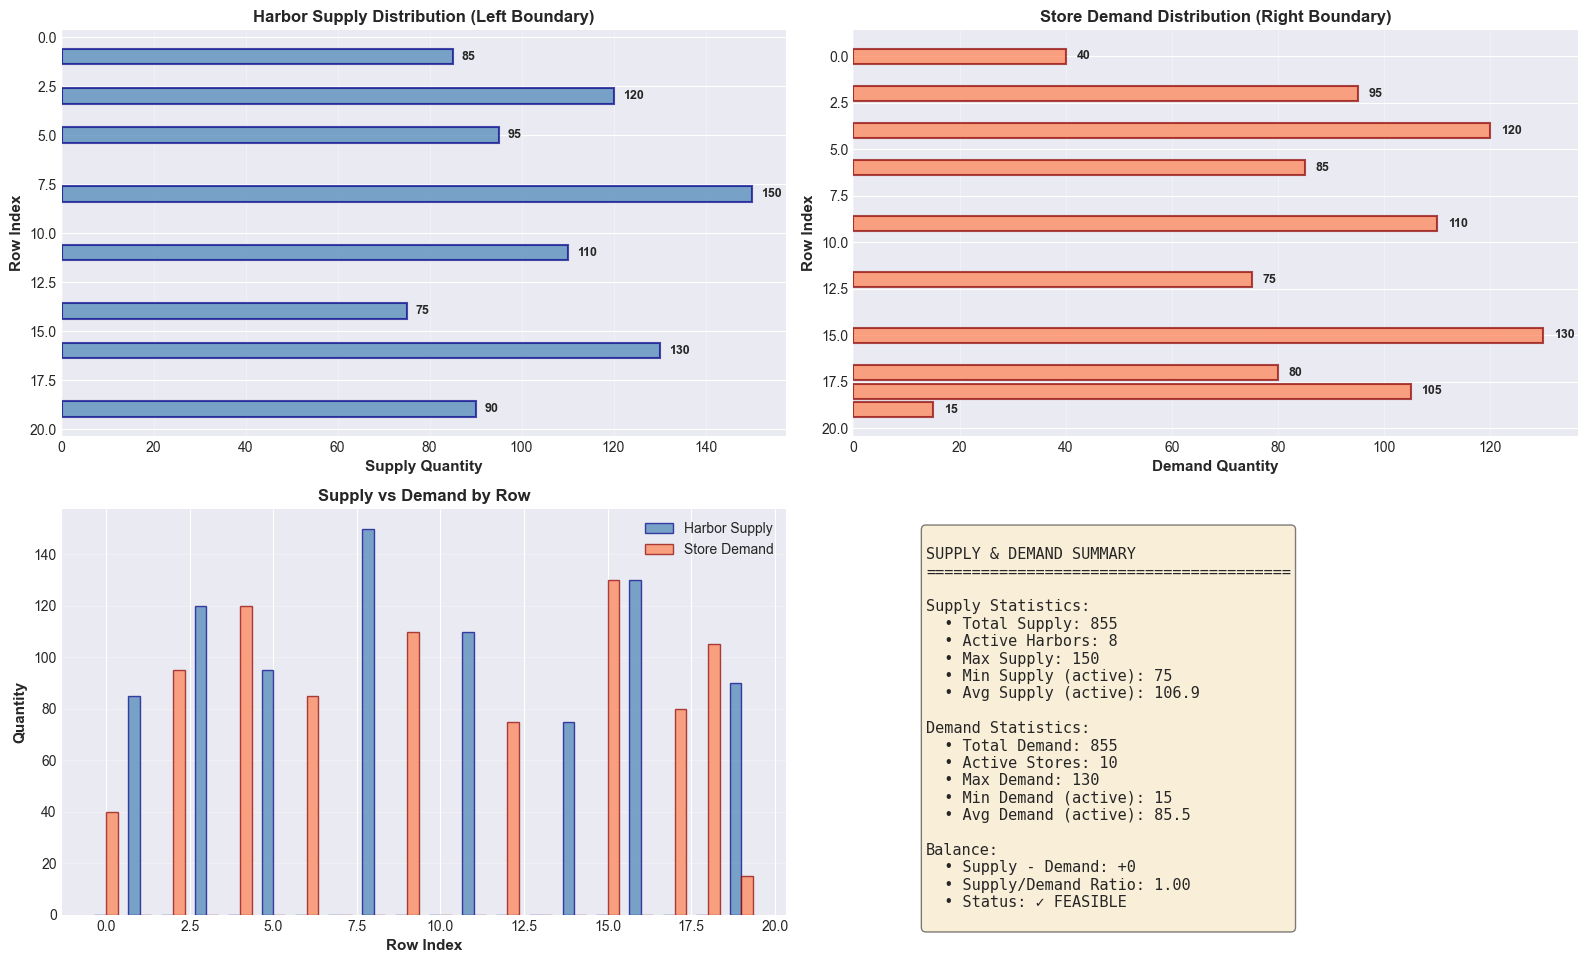


HARBOR-STORE PROXIMITY ANALYSIS

Closest Harbor for each Store (by row distance):
  Store at row 0 (demand=40) → Nearest Harbor at row 1 (supply=85) [distance: 1 rows]
  Store at row 2 (demand=95) → Nearest Harbor at row 1 (supply=85) [distance: 1 rows]
  Store at row 4 (demand=120) → Nearest Harbor at row 3 (supply=120) [distance: 1 rows]
  Store at row 6 (demand=85) → Nearest Harbor at row 5 (supply=95) [distance: 1 rows]
  Store at row 9 (demand=110) → Nearest Harbor at row 8 (supply=150) [distance: 1 rows]
  Store at row 12 (demand=75) → Nearest Harbor at row 11 (supply=110) [distance: 1 rows]
  Store at row 15 (demand=130) → Nearest Harbor at row 14 (supply=75) [distance: 1 rows]
  Store at row 17 (demand=80) → Nearest Harbor at row 16 (supply=130) [distance: 1 rows]
  Store at row 18 (demand=105) → Nearest Harbor at row 19 (supply=90) [distance: 1 rows]
  Store at row 19 (demand=15) → Nearest Harbor at row 19 (supply=90) [distance: 0 rows]


In [20]:
# Harbor supplies (left boundary - one per row)
# Dictionary format: {row_index: supply_quantity}
harbour_dict = {
    0: 0,    # Row 0: No port
    1: 85,   # Row 1: Supply = 85
    2: 0,    # Row 2: No port
    3: 120,  # Row 3: Supply = 120
    4: 0,    # Row 4: No port
    5: 95,   # Row 5: Supply = 95
    6: 0,    # Row 6: No port
    7: 0,    # Row 7: No port
    8: 150,  # Row 8: Supply = 150
    9: 0,    # Row 9: No port
    10: 0,   # Row 10: No port
    11: 110, # Row 11: Supply = 110
    12: 0,   # Row 12: No port
    13: 0,   # Row 13: No port
    14: 75,  # Row 14: Supply = 75
    15: 0,   # Row 15: No port
    16: 130, # Row 16: Supply = 130
    17: 0,   # Row 17: No port
    18: 0,   # Row 18: No port
    19: 90   # Row 19: Supply = 90
}

# Store demands (right boundary - one per row)
# Dictionary format: {row_index: demand_quantity}
stores_dict = {
    0: 40,   # Row 0: Demand = 40
    1: 0,    # Row 1: No store
    2: 95,   # Row 2: Demand = 95
    3: 0,    # Row 3: No store
    4: 120,  # Row 4: Demand = 120
    5: 0,    # Row 5: No store
    6: 85,   # Row 6: Demand = 85
    7: 0,    # Row 7: No store
    8: 0,    # Row 8: No store
    9: 110,  # Row 9: Demand = 110
    10: 0,   # Row 10: No store
    11: 0,   # Row 11: No store
    12: 75,  # Row 12: Demand = 75
    13: 0,   # Row 13: No store
    14: 0,   # Row 14: No store
    15: 130, # Row 15: Demand = 130
    16: 0,   # Row 16: No store
    17: 80,  # Row 17: Demand = 80
    18: 105, # Row 18: Demand = 105
    19: 15   # Row 19: Demand = 15
}

# Convert to numpy arrays for easier computation
harbors = np.array([harbour_dict[i] for i in range(rows)])
stores = np.array([stores_dict[i] for i in range(rows)])

# Calculate totals
total_supply = harbors.sum()
total_demand = stores.sum()
num_harbors = np.count_nonzero(harbors)
num_stores = np.count_nonzero(stores)

print(f"✓ Harbor and Store data loaded!")
print(f"\nSupply Information:")
print(f"  Total Supply (All Harbors): {total_supply}")
print(f"  Number of Active Harbors: {num_harbors}")
print(f"  Average Supply per Active Harbor: {total_supply / num_harbors:.2f}")

print(f"\nDemand Information:")
print(f"  Total Demand (All Stores): {total_demand}")
print(f"  Number of Active Stores: {num_stores}")
print(f"  Average Demand per Active Store: {total_demand / num_stores:.2f}")

print(f"\nSupply/Demand Balance:")
print(f"  Supply - Demand = {total_supply - total_demand}")
if total_supply >= total_demand:
    print(f"  ✓ Supply is sufficient (surplus: {total_supply - total_demand})")
else:
    print(f"  ✗ Supply is insufficient (shortage: {total_demand - total_supply})")

# Display as DataFrame
supply_demand_df = pd.DataFrame({
    'Row': range(rows),
    'Harbor Supply': harbors,
    'Store Demand': stores,
    'Net Flow': harbors - stores
})

print("\nDetailed Supply & Demand by Row:")
print(supply_demand_df)

# Show only active rows (where there's supply or demand)
active_rows = supply_demand_df[(supply_demand_df['Harbor Supply'] > 0) |
                                (supply_demand_df['Store Demand'] > 0)]
print("\nActive Rows Only (with Supply or Demand):")
print(active_rows)

# Visualize supply and demand
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Subplot 1: Harbor Supply
ax1 = axes[0, 0]
harbor_rows = [i for i in range(rows) if harbors[i] > 0]
harbor_values = [harbors[i] for i in harbor_rows]
ax1.barh(harbor_rows, harbor_values, color='steelblue', alpha=0.7, edgecolor='darkblue', linewidth=1.5)
ax1.set_xlabel('Supply Quantity', fontsize=11, fontweight='bold')
ax1.set_ylabel('Row Index', fontsize=11, fontweight='bold')
ax1.set_title('Harbor Supply Distribution (Left Boundary)', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
for i, v in zip(harbor_rows, harbor_values):
    ax1.text(v + 2, i, str(v), va='center', fontweight='bold', fontsize=9)

# Subplot 2: Store Demand
ax2 = axes[0, 1]
store_rows = [i for i in range(rows) if stores[i] > 0]
store_values = [stores[i] for i in store_rows]
ax2.barh(store_rows, store_values, color='coral', alpha=0.7, edgecolor='darkred', linewidth=1.5)
ax2.set_xlabel('Demand Quantity', fontsize=11, fontweight='bold')
ax2.set_ylabel('Row Index', fontsize=11, fontweight='bold')
ax2.set_title('Store Demand Distribution (Right Boundary)', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
for i, v in zip(store_rows, store_values):
    ax2.text(v + 2, i, str(v), va='center', fontweight='bold', fontsize=9)

# Subplot 3: Combined view
ax3 = axes[1, 0]
x_pos = np.arange(rows)
width = 0.35
bars1 = ax3.bar(x_pos - width/2, harbors, width, label='Harbor Supply',
                color='steelblue', alpha=0.7, edgecolor='darkblue')
bars2 = ax3.bar(x_pos + width/2, stores, width, label='Store Demand',
                color='coral', alpha=0.7, edgecolor='darkred')
ax3.set_xlabel('Row Index', fontsize=11, fontweight='bold')
ax3.set_ylabel('Quantity', fontsize=11, fontweight='bold')
ax3.set_title('Supply vs Demand by Row', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Subplot 4: Summary statistics
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
SUPPLY & DEMAND SUMMARY
{'='*40}

Supply Statistics:
  • Total Supply: {total_supply:,}
  • Active Harbors: {num_harbors}
  • Max Supply: {harbors.max()}
  • Min Supply (active): {harbors[harbors > 0].min()}
  • Avg Supply (active): {total_supply / num_harbors:.1f}

Demand Statistics:
  • Total Demand: {total_demand:,}
  • Active Stores: {num_stores}
  • Max Demand: {stores.max()}
  • Min Demand (active): {stores[stores > 0].min()}
  • Avg Demand (active): {total_demand / num_stores:.1f}

Balance:
  • Supply - Demand: {total_supply - total_demand:+,}
  • Supply/Demand Ratio: {total_supply / total_demand:.2f}
  • Status: {'✓ FEASIBLE' if total_supply >= total_demand else '✗ INFEASIBLE'}
"""

ax4.text(0.1, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Additional analysis: Harbor-Store pairs closest to each other
print("\n" + "="*60)
print("HARBOR-STORE PROXIMITY ANALYSIS")
print("="*60)

harbor_positions = [(i, 0) for i in range(rows) if harbors[i] > 0]
store_positions = [(i, cols) for i in range(rows) if stores[i] > 0]

print("\nClosest Harbor for each Store (by row distance):")
for store_row, store_col in store_positions:
    min_dist = float('inf')
    closest_harbor = None
    for harbor_row, harbor_col in harbor_positions:
        dist = abs(store_row - harbor_row)
        if dist < min_dist:
            min_dist = dist
            closest_harbor = harbor_row
    print(f"  Store at row {store_row} (demand={stores[store_row]}) → "
          f"Nearest Harbor at row {closest_harbor} (supply={harbors[closest_harbor]}) "
          f"[distance: {min_dist} rows]")

# CELL 5: Helper Functions - Network Building


In [21]:
def get_intersection_neighbors(i, j, map_grid):
    """
    Get the 4 regions around an intersection point (i,j)
    Intersection (i,j) is at the corner where 4 cells meet
    """
    rows, cols = map_grid.shape
    neighbors = []

    # Top-left cell
    if i > 0 and j > 0:
        neighbors.append(map_grid[i-1, j-1])
    # Top-right cell
    if i > 0 and j < cols:
        neighbors.append(map_grid[i-1, j])
    # Bottom-left cell
    if i < rows and j > 0:
        neighbors.append(map_grid[i, j-1])
    # Bottom-right cell
    if i < rows and j < cols:
        neighbors.append(map_grid[i, j])

    return neighbors

def calculate_inventory_cost(i, j, map_grid):
    """Calculate setup cost for inventory at intersection (i,j)"""
    neighbors = get_intersection_neighbors(i, j, map_grid)
    return sum(INVENTORY_SETUP_COSTS[terrain] for terrain in neighbors)

def calculate_inventory_capacity(i, j, map_grid):
    """Calculate capacity for inventory at intersection (i,j)"""
    neighbors = get_intersection_neighbors(i, j, map_grid)
    return sum(INVENTORY_CAPACITIES[terrain] for terrain in neighbors)

def can_traverse_edge(r1, c1, r2, c2, map_grid):
    """
    Check if edge between two cells can be traversed
    Cannot traverse between same terrain types
    """
    rows, cols = map_grid.shape

    # Check if cells are valid
    if r1 < 0 or r1 >= rows or c1 < 0 or c1 >= cols:
        return False
    if r2 < 0 or r2 >= rows or c2 < 0 or c2 >= cols:
        return False

    # Cells must be adjacent (Manhattan distance = 1)
    if abs(r1 - r2) + abs(c1 - c2) != 1:
        return False

    terrain1 = map_grid[r1, c1]
    terrain2 = map_grid[r2, c2]

    # Cannot traverse between same terrain types
    return terrain1 != terrain2

def get_edge_cost(r1, c1, r2, c2, map_grid):
    """Calculate cost of edge between two adjacent cells"""
    if not can_traverse_edge(r1, c1, r2, c2, map_grid):
        return float('inf')

    terrain1 = map_grid[r1, c1]
    terrain2 = map_grid[r2, c2]

    # Cost is sum of both terrain costs
    return TRANSPORT_COSTS[terrain1] + TRANSPORT_COSTS[terrain2]

print("✓ Helper functions defined!")

# Test the functions
test_intersection = (5, 10)
print(f"\nTest intersection {test_intersection}:")
print(f"  Setup cost: {calculate_inventory_cost(*test_intersection, map_grid)}")
print(f"  Capacity: {calculate_inventory_capacity(*test_intersection, map_grid)}")
print(f"  Neighbors: {get_intersection_neighbors(*test_intersection, map_grid)}")

✓ Helper functions defined!

Test intersection (5, 10):
  Setup cost: 3400
  Capacity: 65
  Neighbors: [np.int64(6), np.int64(1), np.int64(1), np.int64(4)]


# CELL 6: Build Network Graph


Building network graph...
✓ Network graph built in 0.004 seconds
  Total valid edges: 948

Edge Cost Statistics:
  Min cost: 60
  Max cost: 200
  Average cost: 124.03
  Median cost: 130.00


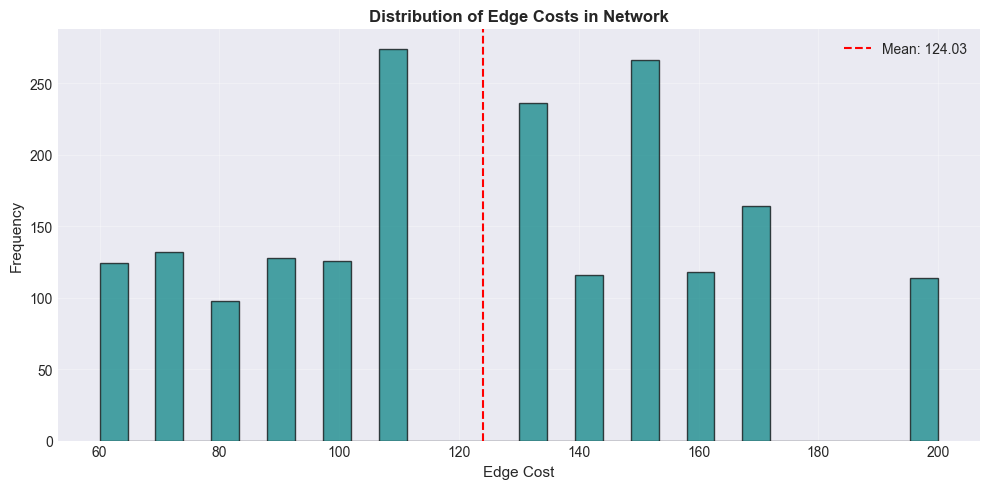

In [22]:
def build_network_graph(map_grid):
    """
    Build network graph with edges and costs
    Returns: adjacency list with edge costs
    """
    rows, cols = map_grid.shape
    graph = defaultdict(list)
    edge_costs = {}

    # Build cell-to-cell edges
    for r in range(rows):
        for c in range(cols):
            # Check right neighbor
            if c + 1 < cols:
                cost = get_edge_cost(r, c, r, c + 1, map_grid)
                if cost < float('inf'):
                    graph[(r, c)].append((r, c + 1))
                    graph[(r, c + 1)].append((r, c))
                    edge_costs[((r, c), (r, c + 1))] = cost
                    edge_costs[((r, c + 1), (r, c))] = cost

            # Check bottom neighbor
            if r + 1 < rows:
                cost = get_edge_cost(r, c, r + 1, c, map_grid)
                if cost < float('inf'):
                    graph[(r, c)].append((r + 1, c))
                    graph[(r + 1, c)].append((r, c))
                    edge_costs[((r, c), (r + 1, c))] = cost
                    edge_costs[((r + 1, c), (r, c))] = cost

    return graph, edge_costs

# Build the graph
print("Building network graph...")
start_time = time.time()
graph, edge_costs = build_network_graph(map_grid)
build_time = time.time() - start_time

print(f"✓ Network graph built in {build_time:.3f} seconds")
print(f"  Total valid edges: {len(edge_costs) // 2}")

# Analyze edge cost distribution
costs_list = [cost for cost in edge_costs.values()]
print(f"\nEdge Cost Statistics:")
print(f"  Min cost: {min(costs_list)}")
print(f"  Max cost: {max(costs_list)}")
print(f"  Average cost: {np.mean(costs_list):.2f}")
print(f"  Median cost: {np.median(costs_list):.2f}")

# Plot edge cost distribution
plt.figure(figsize=(10, 5))
plt.hist(costs_list, bins=30, color='teal', alpha=0.7, edgecolor='black')
plt.xlabel('Edge Cost', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Edge Costs in Network', fontsize=12, fontweight='bold')
plt.axvline(np.mean(costs_list), color='red', linestyle='--', label=f'Mean: {np.mean(costs_list):.2f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# CELL 7: Dijkstra's Shortest Path Algorithm


In [23]:
def dijkstra_shortest_path(graph, edge_costs, start, end):
    """
    Find shortest path from start to end using Dijkstra's algorithm
    Returns: (distance, path)
    """
    if start == end:
        return 0, [start]

    # Priority queue: (distance, node, path)
    pq = [(0, start, [start])]
    visited = set()
    distances = {start: 0}

    while pq:
        current_dist, current_node, path = heapq.heappop(pq)

        if current_node in visited:
            continue

        visited.add(current_node)

        if current_node == end:
            return current_dist, path

        # Explore neighbors
        for neighbor in graph.get(current_node, []):
            if neighbor in visited:
                continue

            edge_cost = edge_costs.get((current_node, neighbor), float('inf'))
            new_dist = current_dist + edge_cost

            if neighbor not in distances or new_dist < distances[neighbor]:
                distances[neighbor] = new_dist
                heapq.heappush(pq, (new_dist, neighbor, path + [neighbor]))

    return float('inf'), []

def get_shortest_distance(graph, edge_costs, start, end):
    """Get only the distance (faster when path is not needed)"""
    dist, _ = dijkstra_shortest_path(graph, edge_costs, start, end)
    return dist

print("✓ Dijkstra's algorithm implemented!")

# Test the algorithm
test_start = (0, 0)
test_end = (rows-1, cols-1)
print(f"\nTesting shortest path from {test_start} to {test_end}...")
start_time = time.time()
distance, path = dijkstra_shortest_path(graph, edge_costs, test_start, test_end)
test_time = time.time() - start_time

if distance < float('inf'):
    print(f"  ✓ Path found!")
    print(f"  Distance: {distance:.2f}")
    print(f"  Path length: {len(path)} cells")
    print(f"  Computation time: {test_time:.4f} seconds")
else:
    print(f"  ✗ No path exists between these points")

✓ Dijkstra's algorithm implemented!

Testing shortest path from (0, 0) to (19, 29)...
  ✓ Path found!
  Distance: 5260.00
  Path length: 49 cells
  Computation time: 0.0014 seconds


# CELL 8: Identify All Valid Intersection Points


Identifying valid intersections...
✓ Intersections identified in 0.006 seconds
  Total valid intersections: 609

Intersection Statistics:
  Setup cost - Min: 600, Max: 4800, Avg: 2717.24
  Capacity - Min: 20, Max: 115, Avg: 72.35

Sample intersections:
   row  col  setup_cost  capacity
0    0    1        1000        60
1    0    2        1200        40
2    0    3        1400        20
3    0    4        1300        30
4    0    5        1200        40
5    0    6         900        45
6    0    7        1000        35
7    0    8        1900        25
8    0    9        1900        25
9    0   10        1200        40


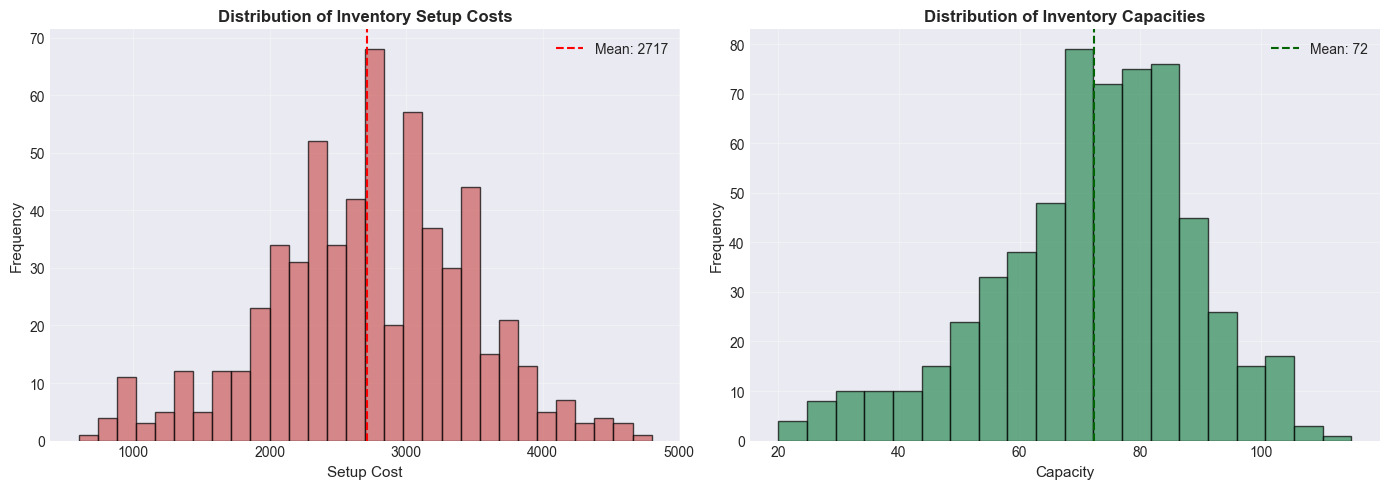

In [24]:
def identify_valid_intersections(map_grid):
    """
    Identify all intersection points and calculate their properties
    Returns: DataFrame with intersection details
    """
    rows, cols = map_grid.shape
    intersections = []

    for i in range(rows + 1):
        for j in range(cols + 1):
            # Skip left and right boundaries (reserved for harbors and stores)
            if j == 0 or j == cols:
                continue

            # Calculate properties
            neighbors = get_intersection_neighbors(i, j, map_grid)
            setup_cost = calculate_inventory_cost(i, j, map_grid)
            capacity = calculate_inventory_capacity(i, j, map_grid)

            intersections.append({
                'row': i,
                'col': j,
                'position': (i, j),
                'setup_cost': setup_cost,
                'capacity': capacity,
                'num_neighbors': len(neighbors),
                'neighbors': neighbors
            })

    return pd.DataFrame(intersections)

# Build intersection database
print("Identifying valid intersections...")
start_time = time.time()
intersections_df = identify_valid_intersections(map_grid)
id_time = time.time() - start_time

print(f"✓ Intersections identified in {id_time:.3f} seconds")
print(f"  Total valid intersections: {len(intersections_df)}")
print(f"\nIntersection Statistics:")
print(f"  Setup cost - Min: {intersections_df['setup_cost'].min()}, Max: {intersections_df['setup_cost'].max()}, Avg: {intersections_df['setup_cost'].mean():.2f}")
print(f"  Capacity - Min: {intersections_df['capacity'].min()}, Max: {intersections_df['capacity'].max()}, Avg: {intersections_df['capacity'].mean():.2f}")

# Display sample intersections
print("\nSample intersections:")
print(intersections_df.head(10)[['row', 'col', 'setup_cost', 'capacity']])

# Visualize cost and capacity distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(intersections_df['setup_cost'], bins=30, color='indianred', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Setup Cost', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of Inventory Setup Costs', fontsize=12, fontweight='bold')
ax1.axvline(intersections_df['setup_cost'].mean(), color='red', linestyle='--',
            label=f'Mean: {intersections_df["setup_cost"].mean():.0f}')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.hist(intersections_df['capacity'], bins=20, color='seagreen', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Capacity', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution of Inventory Capacities', fontsize=12, fontweight='bold')
ax2.axvline(intersections_df['capacity'].mean(), color='darkgreen', linestyle='--',
            label=f'Mean: {intersections_df["capacity"].mean():.0f}')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# CELL 9: Part 1 - Greedy Heuristic for Inventory Selection


In [25]:
def check_minimum_distance_constraint(inv_pos, existing_invs, harbor_positions, min_dist=MIN_DISTANCE):
    """
    Check if inventory position satisfies minimum distance constraint
    Distance is measured as Manhattan distance (number of edges)
    """
    i, j = inv_pos

    # Check distance from other inventories
    for other in existing_invs:
        other_i, other_j = other
        manhattan_dist = abs(i - other_i) + abs(j - other_j)
        if manhattan_dist < min_dist:
            return False

    # Check distance from harbors (left boundary)
    for h_row, h_col in harbor_positions:
        manhattan_dist = abs(i - h_row) + abs(j - h_col)
        if manhattan_dist < min_dist:
            return False

    return True

def greedy_inventory_selection(intersections_df, harbors, stores, map_grid, graph, edge_costs):
    """
    Greedy heuristic to select inventory locations
    Strategy: Minimize total distance to harbors and stores while respecting constraints
    """
    rows, cols = map_grid.shape

    # Harbor and store positions
    harbor_positions = [(i, 0) for i in range(rows)]
    store_positions = [(i, cols) for i in range(rows)]

    total_demand = stores.sum()
    total_supply = harbors.sum()

    selected_inventories = []

    # Score each intersection
    print("Scoring intersections...")
    scored_intersections = []

    for idx, row in intersections_df.iterrows():
        inv_pos = row['position']
        i, j = inv_pos

        # Calculate average distance to harbors (using Manhattan distance as proxy)
        avg_dist_harbor = sum(abs(i - h_i) + abs(j - h_j)
                             for h_i, h_j in harbor_positions) / len(harbor_positions)

        # Calculate average distance to stores
        avg_dist_store = sum(abs(i - s_i) + abs(j - s_j)
                            for s_i, s_j in store_positions) / len(store_positions)

        total_dist = avg_dist_harbor + avg_dist_store
        setup_cost = row['setup_cost']
        capacity = row['capacity']

        # Score formula: minimize distance and cost, maximize capacity
        # Lower score is better
        score = total_dist * 2 + setup_cost * 0.01 - capacity * 3

        scored_intersections.append({
            'position': inv_pos,
            'score': score,
            'setup_cost': setup_cost,
            'capacity': capacity,
            'avg_dist': total_dist
        })

    # Sort by score (lower is better)
    scored_intersections.sort(key=lambda x: x['score'])

    print("Selecting inventories greedily...")

    # Greedily select inventories
    for item in scored_intersections:
        inv_pos = item['position']

        # Stop if we have max inventories
        if len(selected_inventories) >= MAX_INVENTORIES:
            break

        # Check minimum distance constraint
        if check_minimum_distance_constraint(inv_pos, selected_inventories, harbor_positions):
            selected_inventories.append(inv_pos)

            # Check if we have sufficient capacity
            total_capacity = sum(intersections_df[intersections_df['position'] == inv]['capacity'].values[0]
                               for inv in selected_inventories)

            if total_capacity >= total_demand and len(selected_inventories) >= MIN_INVENTORIES:
                break

    # Ensure minimum number of inventories
    if len(selected_inventories) < MIN_INVENTORIES:
        print(f"  Warning: Only {len(selected_inventories)} inventories selected, need at least {MIN_INVENTORIES}")
        # Add more if needed
        for item in scored_intersections:
            if item['position'] not in selected_inventories:
                selected_inventories.append(item['position'])
                if len(selected_inventories) >= MIN_INVENTORIES:
                    break

    return selected_inventories

# Run greedy selection
print("="*60)
print("PART 1: GREEDY HEURISTIC")
print("="*60)

start_time = time.time()
initial_solution = greedy_inventory_selection(intersections_df, harbors, stores, map_grid, graph, edge_costs)
greedy_time = time.time() - start_time

print(f"\n✓ Greedy selection completed in {greedy_time:.3f} seconds")
print(f"  Number of inventories selected: {len(initial_solution)}")

# Calculate properties of selected inventories
selected_data = []
for inv_pos in initial_solution:
    inv_row = intersections_df[intersections_df['position'] == inv_pos].iloc[0]
    selected_data.append({
        'Position': inv_pos,
        'Setup Cost': inv_row['setup_cost'],
        'Capacity': inv_row['capacity']
    })

selected_df = pd.DataFrame(selected_data)
print("\nSelected Inventories:")
print(selected_df)

total_setup_cost = selected_df['Setup Cost'].sum()
total_capacity = selected_df['Capacity'].sum()
print(f"\nTotal Setup Cost: {total_setup_cost:,.0f}")
print(f"Total Capacity: {total_capacity}")
print(f"Total Demand: {stores.sum()}")
print(f"Capacity Utilization: {stores.sum() / total_capacity * 100:.1f}%")

PART 1: GREEDY HEURISTIC
Scoring intersections...
Selecting inventories greedily...

✓ Greedy selection completed in 0.041 seconds
  Number of inventories selected: 8

Selected Inventories:
   Position  Setup Cost  Capacity
0    (8, 5)        1800       115
1   (4, 29)        1600       110
2   (15, 7)        1600       110
3   (10, 7)        1900       105
4  (11, 19)        1900       105
5  (14, 11)        1900       105
6    (4, 4)        1900       105
7   (8, 29)        2700       105

Total Setup Cost: 15,300
Total Capacity: 860
Total Demand: 855
Capacity Utilization: 99.4%


# CELL 10: Part 1 - Calculate Total Cost and Local Search Optimization


In [26]:
def calculate_solution_cost(selected_inventories, harbors, stores, map_grid,
                           graph, edge_costs, intersections_df):
    """
    Calculate total cost of a solution including:
    1. Inventory setup costs
    2. Transportation costs (harbor -> inventory -> store)
    3. Shortage penalties
    """
    rows, cols = map_grid.shape

    # 1. Setup costs
    setup_cost = 0
    for inv_pos in selected_inventories:
        inv_row = intersections_df[intersections_df['position'] == inv_pos].iloc[0]
        setup_cost += inv_row['setup_cost']

    # 2. Transportation costs
    # For simplicity, assign each harbor to nearest inventory and each store to nearest inventory
    # In reality, this would be solved with min-cost flow

    transport_cost = 0

    # Harbor to inventory
    for h_idx in range(rows):
        if harbors[h_idx] > 0:
            harbor_cell = (h_idx, 0)  # Left boundary

            # Find nearest inventory
            min_dist = float('inf')
            for inv_pos in selected_inventories:
                # Approximate distance (Manhattan * average edge cost)
                avg_edge_cost = sum(edge_costs.values()) / len(edge_costs)
                dist = (abs(harbor_cell[0] - inv_pos[0]) + abs(harbor_cell[1] - inv_pos[1])) * avg_edge_cost * 0.5
                min_dist = min(min_dist, dist)

            transport_cost += min_dist * harbors[h_idx]

    # Inventory to store
    for s_idx in range(rows):
        if stores[s_idx] > 0:
            store_cell = (s_idx, cols - 1)  # Right boundary (approximation)

            # Find nearest inventory
            min_dist = float('inf')
            for inv_pos in selected_inventories:
                # Approximate distance
                avg_edge_cost = sum(edge_costs.values()) / len(edge_costs)
                dist = (abs(store_cell[0] - inv_pos[0]) + abs(store_cell[1] - inv_pos[1])) * avg_edge_cost * 0.5
                min_dist = min(min_dist, dist)

            transport_cost += min_dist * stores[s_idx]

    # 3. Shortage penalty
    total_capacity = sum(intersections_df[intersections_df['position'] == inv]['capacity'].values[0]
                        for inv in selected_inventories)
    total_demand = stores.sum()

    shortage = max(0, total_demand - total_capacity)
    penalty_cost = shortage * SHORTAGE_PENALTY

    total_cost = setup_cost + transport_cost + penalty_cost

    return {
        'total': total_cost,
        'setup': setup_cost,
        'transport': transport_cost,
        'penalty': penalty_cost,
        'shortage': shortage
    }

# Calculate initial solution cost
print("\n" + "="*60)
print("INITIAL SOLUTION EVALUATION")
print("="*60)

initial_cost = calculate_solution_cost(initial_solution, harbors, stores, map_grid,
                                      graph, edge_costs, intersections_df)

print(f"\nCost Breakdown:")
print(f"  Setup Cost:        {initial_cost['setup']:>12,.2f}")
print(f"  Transport Cost:    {initial_cost['transport']:>12,.2f}")
print(f"  Penalty Cost:      {initial_cost['penalty']:>12,.2f}")
print(f"  " + "-"*35)
print(f"  TOTAL COST:        {initial_cost['total']:>12,.2f}")
print(f"\nShortage: {initial_cost['shortage']:.0f} units")


INITIAL SOLUTION EVALUATION

Cost Breakdown:
  Setup Cost:           15,300.00
  Transport Cost:      601,853.32
  Penalty Cost:              0.00
  -----------------------------------
  TOTAL COST:          617,153.32

Shortage: 0 units


# CELL 10B: Local Search Optimization


In [27]:
def local_search_optimization(initial_solution, harbors, stores, map_grid,
                             graph, edge_costs, intersections_df, max_iterations=50):
    """
    Local search to improve solution
    Moves: swap, add, remove inventories
    """
    rows, cols = map_grid.shape
    harbor_positions = [(i, 0) for i in range(rows)]

    current_solution = initial_solution.copy()
    current_cost_info = calculate_solution_cost(current_solution, harbors, stores,
                                                map_grid, graph, edge_costs, intersections_df)
    current_cost = current_cost_info['total']

    best_solution = current_solution.copy()
    best_cost = current_cost

    print("\n" + "="*60)
    print("LOCAL SEARCH OPTIMIZATION")
    print("="*60)
    print(f"Starting cost: {current_cost:,.2f}")

    improvements = []
    no_improvement_count = 0

    for iteration in range(max_iterations):
        improved = False

        # Try 1: Swap one inventory with a candidate
        for i, inv in enumerate(current_solution):
            # Sample some candidate positions
            candidates = intersections_df.sample(min(30, len(intersections_df)))

            for _, candidate_row in candidates.iterrows():
                candidate_pos = candidate_row['position']

                if candidate_pos in current_solution:
                    continue

                # Try swap
                test_solution = current_solution.copy()
                test_solution[i] = candidate_pos

                # Check minimum distance constraint
                other_invs = [inv for j, inv in enumerate(test_solution) if j != i]
                if not check_minimum_distance_constraint(candidate_pos, other_invs, harbor_positions):
                    continue

                # Calculate cost
                test_cost_info = calculate_solution_cost(test_solution, harbors, stores,
                                                        map_grid, graph, edge_costs, intersections_df)
                test_cost = test_cost_info['total']

                if test_cost < current_cost:
                    current_solution = test_solution
                    current_cost = test_cost
                    improved = True
                    improvements.append((iteration, current_cost))
                    print(f"  Iteration {iteration+1}: Improved! New cost = {current_cost:,.2f} (swap at index {i})")
                    break

            if improved:
                break

        # Try 2: Add an inventory (if under max limit)
        if not improved and len(current_solution) < MAX_INVENTORIES:
            candidates = intersections_df.sample(min(20, len(intersections_df)))

            for _, candidate_row in candidates.iterrows():
                candidate_pos = candidate_row['position']

                if candidate_pos in current_solution:
                    continue

                # Try adding
                test_solution = current_solution + [candidate_pos]

                # Check constraints
                if not check_minimum_distance_constraint(candidate_pos, current_solution, harbor_positions):
                    continue

                # Calculate cost
                test_cost_info = calculate_solution_cost(test_solution, harbors, stores,
                                                        map_grid, graph, edge_costs, intersections_df)
                test_cost = test_cost_info['total']

                if test_cost < current_cost:
                    current_solution = test_solution
                    current_cost = test_cost
                    improved = True
                    improvements.append((iteration, current_cost))
                    print(f"  Iteration {iteration+1}: Improved! New cost = {current_cost:,.2f} (added inventory)")
                    break

        # Try 3: Remove an inventory (if above min limit)
        if not improved and len(current_solution) > MIN_INVENTORIES:
            for i in range(len(current_solution)):
                test_solution = current_solution[:i] + current_solution[i+1:]

                # Calculate cost
                test_cost_info = calculate_solution_cost(test_solution, harbors, stores,
                                                        map_grid, graph, edge_costs, intersections_df)
                test_cost = test_cost_info['total']

                if test_cost < current_cost:
                    current_solution = test_solution
                    current_cost = test_cost
                    improved = True
                    improvements.append((iteration, current_cost))
                    print(f"  Iteration {iteration+1}: Improved! New cost = {current_cost:,.2f} (removed inventory {i})")
                    break

        if improved:
            no_improvement_count = 0
            if current_cost < best_cost:
                best_solution = current_solution.copy()
                best_cost = current_cost
        else:
            no_improvement_count += 1
            if no_improvement_count >= 10:  # Early stopping
                print(f"\n  No improvement for 10 iterations. Stopping early at iteration {iteration+1}.")
                break

    return best_solution, best_cost, improvements

# Run local search
start_time = time.time()
final_solution, final_cost, improvements = local_search_optimization(
    initial_solution, harbors, stores, map_grid, graph, edge_costs, intersections_df
)
ls_time = time.time() - start_time

print(f"\n✓ Local search completed in {ls_time:.3f} seconds")
print(f"  Final cost: {final_cost:,.2f}")
print(f"  Improvement: {((initial_cost['total'] - final_cost) / initial_cost['total'] * 100):.2f}%")
print(f"  Number of improvements: {len(improvements)}")


LOCAL SEARCH OPTIMIZATION
Starting cost: 617,153.32
  Iteration 1: Improved! New cost = 570,548.10 (swap at index 3)
  Iteration 2: Improved! New cost = 556,904.85 (swap at index 4)
  Iteration 3: Improved! New cost = 539,110.50 (swap at index 2)
  Iteration 5: Improved! New cost = 536,903.90 (swap at index 3)
  Iteration 7: Improved! New cost = 520,780.06 (swap at index 3)
  Iteration 15: Improved! New cost = 507,565.30 (swap at index 3)
  Iteration 18: Improved! New cost = 494,542.19 (swap at index 5)
  Iteration 19: Improved! New cost = 454,044.41 (swap at index 3)

  No improvement for 10 iterations. Stopping early at iteration 29.

✓ Local search completed in 27.472 seconds
  Final cost: 454,044.41
  Improvement: 26.43%
  Number of improvements: 8


# CELL 11: Visualize Final Solution



FINAL SOLUTION - PART 1

Final Cost Breakdown:
  Setup Cost:           15,600.00
  Transport Cost:      438,444.41
  Penalty Cost:              0.00
  -----------------------------------
  TOTAL COST:          454,044.41

Solution Details:
  Number of inventories: 8
  Total capacity: 855
  Total demand: 855
  Shortage: 0 units

Selected Inventory Locations:
   Position  Row  Col  Setup Cost  Capacity
0    (8, 5)    8    5        1800       115
1   (4, 29)    4   29        1600       110
2   (15, 6)   15    6        2100       110
3  (11, 16)   11   16        1700       100
4   (11, 6)   11    6        1900       105
5  (17, 28)   17   28        1900       105
6    (4, 4)    4    4        1900       105
7   (8, 29)    8   29        2700       105


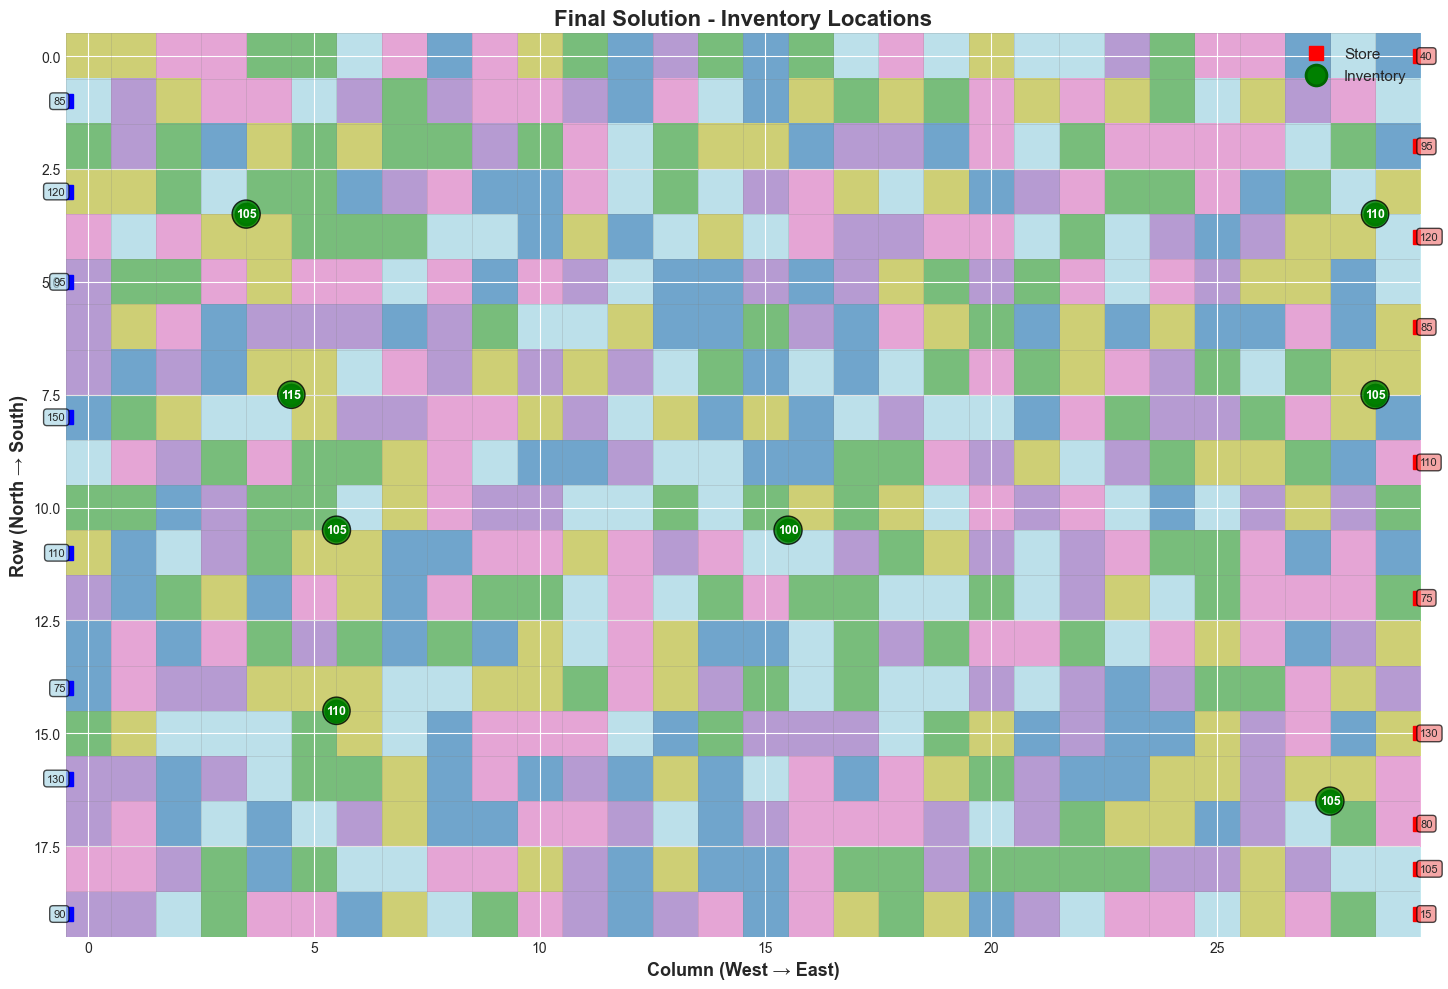

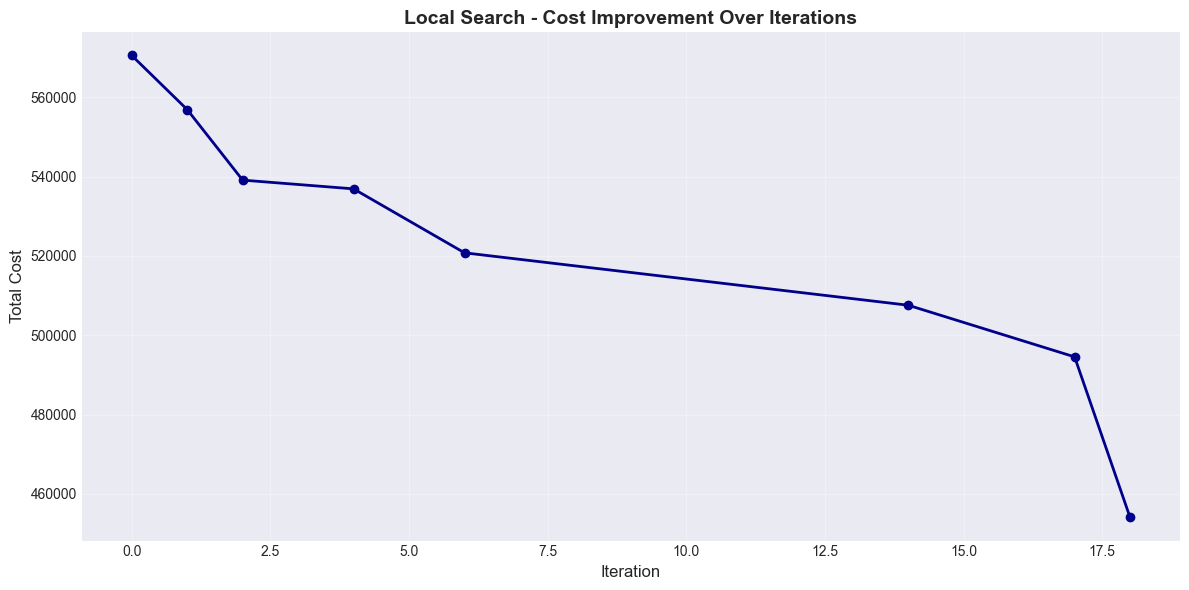

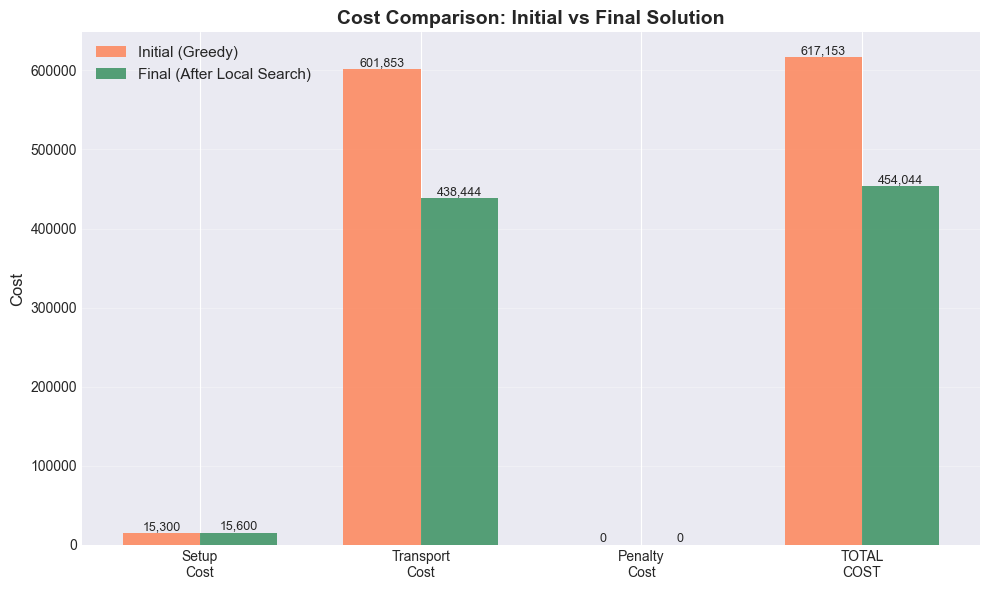


PART 1 COMPLETE!
Total computation time: 27.514 seconds


In [28]:
# Calculate final cost breakdown
final_cost_info = calculate_solution_cost(final_solution, harbors, stores, map_grid,
                                         graph, edge_costs, intersections_df)

print("\n" + "="*60)
print("FINAL SOLUTION - PART 1")
print("="*60)

print(f"\nFinal Cost Breakdown:")
print(f"  Setup Cost:        {final_cost_info['setup']:>12,.2f}")
print(f"  Transport Cost:    {final_cost_info['transport']:>12,.2f}")
print(f"  Penalty Cost:      {final_cost_info['penalty']:>12,.2f}")
print(f"  " + "-"*35)
print(f"  TOTAL COST:        {final_cost_info['total']:>12,.2f}")

print(f"\nSolution Details:")
print(f"  Number of inventories: {len(final_solution)}")
print(f"  Total capacity: {sum(intersections_df[intersections_df['position'] == inv]['capacity'].values[0] for inv in final_solution)}")
print(f"  Total demand: {stores.sum()}")
print(f"  Shortage: {final_cost_info['shortage']:.0f} units")

# Create detailed dataframe
final_inv_data = []
for inv_pos in final_solution:
    inv_row = intersections_df[intersections_df['position'] == inv_pos].iloc[0]
    final_inv_data.append({
        'Position': inv_pos,
        'Row': inv_pos[0],
        'Col': inv_pos[1],
        'Setup Cost': inv_row['setup_cost'],
        'Capacity': inv_row['capacity']
    })

final_inv_df = pd.DataFrame(final_inv_data)
print("\nSelected Inventory Locations:")
print(final_inv_df)

# Visualization 1: Map with solution
fig, ax = plt.subplots(figsize=(18, 10))

# Show map
im = ax.imshow(map_grid, cmap='tab20', interpolation='nearest', alpha=0.6)

# Add grid
for i in range(rows + 1):
    ax.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.3)
for j in range(cols + 1):
    ax.axvline(j - 0.5, color='gray', linewidth=0.5, alpha=0.3)

# Mark harbors (left boundary)
for i in range(rows):
    if harbors[i] > 0:
        ax.plot(-0.5, i, 'bs', markersize=10, label='Harbor' if i == 0 else '')
        ax.text(-0.5, i, f'{harbors[i]}', fontsize=8, ha='right', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

# Mark stores (right boundary)
for i in range(rows):
    if stores[i] > 0:
        ax.plot(cols - 0.5, i, 'rs', markersize=10, label='Store' if i == 0 else '')
        ax.text(cols - 0.5, i, f'{stores[i]}', fontsize=8, ha='left', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))

# Mark selected inventories
for inv_pos in final_solution:
    i, j = inv_pos
    inv_row = intersections_df[intersections_df['position'] == inv_pos].iloc[0]
    capacity = inv_row['capacity']

    ax.plot(j - 0.5, i - 0.5, 'go', markersize=15, markeredgewidth=2,
           markeredgecolor='darkgreen', label='Inventory' if inv_pos == final_solution[0] else '')
    ax.text(j - 0.5, i - 0.5, f'{capacity}', fontsize=9, ha='center', va='center',
           fontweight='bold', color='white',
           bbox=dict(boxstyle='circle,pad=0.3', facecolor='green', alpha=0.8))

ax.set_xlabel('Column (West → East)', fontsize=13, fontweight='bold')
ax.set_ylabel('Row (North → South)', fontsize=13, fontweight='bold')
ax.set_title('Final Solution - Inventory Locations', fontsize=16, fontweight='bold')

# Remove duplicate labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

# Visualization 2: Cost improvement over iterations
if improvements:
    iterations, costs = zip(*improvements)

    plt.figure(figsize=(12, 6))
    plt.plot(iterations, costs, marker='o', linewidth=2, markersize=6, color='darkblue')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Total Cost', fontsize=12)
    plt.title('Local Search - Cost Improvement Over Iterations', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualization 3: Cost comparison
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Setup\nCost', 'Transport\nCost', 'Penalty\nCost', 'TOTAL\nCOST']
initial_values = [initial_cost['setup'], initial_cost['transport'],
                 initial_cost['penalty'], initial_cost['total']]
final_values = [final_cost_info['setup'], final_cost_info['transport'],
               final_cost_info['penalty'], final_cost_info['total']]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, initial_values, width, label='Initial (Greedy)', color='coral', alpha=0.8)
bars2 = ax.bar(x + width/2, final_values, width, label='Final (After Local Search)', color='seagreen', alpha=0.8)

ax.set_ylabel('Cost', fontsize=12)
ax.set_title('Cost Comparison: Initial vs Final Solution', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:,.0f}',
               ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PART 1 COMPLETE!")
print("="*60)
print(f"Total computation time: {greedy_time + ls_time:.3f} seconds")

# Task Two Modeling

In [29]:
# Install minizinc package (run this in terminal or uncomment)
# !pip install minizinc

import minizinc
from minizinc import Instance, Model, Solver
import sys

print("Testing MiniZinc Installation...")
print("="*60)

try:
    # Try to find MiniZinc automatically
    solver = Solver.lookup("gecode")
    print(f"✓ MiniZinc found successfully!")
    print(f"  Default solver: {solver.name}")
    print(f"  Version: {solver.version}")

except Exception as e:
    print(f"✗ MiniZinc not found automatically")
    print(f"  Error: {e}")
    print("\n" + "="*60)
    print("MANUAL SETUP REQUIRED")
    print("="*60)
    print("\nPlease specify the path to your MiniZinc installation:")
    print("Example for Windows: C:/Program Files/MiniZinc")
    print("\nAdd this code before using MiniZinc:")
    print("""
import os
os.environ['PATH'] = r'C:\\Program Files\\MiniZinc' + os.pathsep + os.environ['PATH']
# Or
minizinc.default_driver.minizinc_path = r'C:\\Program Files\\MiniZinc\\minizinc.exe'
    """)

# Alternative: Set path manually if automatic detection fails
# Uncomment and adjust path if needed:
# import os
# MINIZINC_PATH = r"C:\Program Files\MiniZinc"
# os.environ['PATH'] = MINIZINC_PATH + os.pathsep + os.environ['PATH']

print("\n" + "="*60)
print("Available Solvers:")
print("="*60)
try:
    for s in Solver.available_solvers():
        print(f"  • {s.name} (version {s.version})")
except:
    print("  Could not list solvers - MiniZinc may not be properly configured")

Testing MiniZinc Installation...
✓ MiniZinc found successfully!
  Default solver: Gecode
  Version: 6.3.0

Available Solvers:
  Could not list solvers - MiniZinc may not be properly configured
